# postISR on ComCam GAIA images


In [131]:
# mostly from runCloseLoopPostISR.py 


from lsst.ts.wep.Utility import CamType, DefocalType
from lsst.ts.wep.Utility import FilterType
import os 
#FilterType, getModulePath, mapFilterRefToG, 
#WepController?

In [175]:
# to reload WepController after some code editing,
# need to run the code below - 
# it tells python to removes the name binding. 
# Python only searches sys.modules to see whether 
# the modules had already been imported,
# and if they had, they are not reloaded 
import sys
del sys.modules['lsst.ts.wep.WepController']
del sys.modules['lsst.ts.wep.ctrlIntf.WEPCalculationFactory']
#N.B.  
#import imp
#imp.reload(module)
# works only for modules, not classes! 

from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

In [171]:
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

In [158]:
path_to_ts_wep = '/epyc/users/suberlak/Commissioning/aos/ts_wep/'
bscDataDir = os.path.join(path_to_ts_wep, 'tests/testData')
dbFile = 'bsc.db3'
if dbFile  in os.listdir(bscDataDir):
    os.remove(os.path.join(bscDataDir,dbFile))
    print('Removed old %s file'%dbFile)

In [186]:
# what bscDbType do we want to use ? 
bscDbType = 'refCat'

from lsst.ts.wep.ParamReader import ParamReader
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('Before change: ', settingFile.getSetting("bscDbType"))


# In the following we update the setting for bscDbType saving the change in the default.yaml file 
settingFile.updateSetting("bscDbType", bscDbType)
settingFile.saveSetting(filePath=settingFilePath)

# check that the change indeed took place 
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('After change: ', settingFile.getSetting("bscDbType"))



Before change:  image
After change:  refCat


In [187]:
import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

In [188]:
topDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
closed_loop_input_dir = os.path.join(topDir,'dr2_med_full_2020_24_wide/input/')
raInDeg, decInDeg = at.getRaDecFromGaiaField('med')

For this field, the raInDeg=233.017, decInDeg=-4.447


In [189]:
from lsst.ts.wep.Utility import FilterType
print('Using %s '%closed_loop_input_dir )

# these are basically parts of WEPCalculationFactory.py  calculateWavefrontErrors()
# skipping the ingest and ISR 
wep_calc = WEPCalculationFactory.getCalculator(CamType.ComCam, 
                                               closed_loop_input_dir)

Using /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/ 


In [177]:
# NB : there is actually no way to change the name of the settings file

# the following shows that the settings still get read from the default file:

#wep_calc._configWepController(camType=CamType.ComCam, settingFileName = 'settings.yaml')
#wep_calc.settingFile.getFilePath()



The only way to change the settings is to manually overwrite the 'default.yaml' as far as the database type is concerned, because that part of settings is instantiated together with WEPCalculation(). 

In [190]:
wep_calc.wepCntlr.setPostIsrCcdInputs(os.path.join(closed_loop_input_dir, 'rerun/run2'))
rotAngInDeg = 0.0
wep_calc.setBoresight(raInDeg, decInDeg)
wep_calc.setRotAng(rotAngInDeg)
        
intraObsId = 9006002
extraObsId = 9006001
obsIdList = [intraObsId, extraObsId]
neighborStarMap = wep_calc._getTargetStar(obsIdList, defocalState=DefocalType.Intra)

sensorNameList = list(neighborStarMap)
detector_list = sensorNameList

# Now WEPCalculation.calculateWavefrontErrors()  calls 
# donutMap = self._calcWfErr(neighborStarMap, obsIdList,
#                            postageImg, postageImgDir)
# listOfWfErr = self._populateListOfSensorWavefrontData(donutMap,sensorNameToIdFileName)
     
###
# below are parts of WEPCalculation._calcWfErr() that we are testing : 
###


isrImgMap = wep_calc.wepCntlr.getPostIsrImgMapByPistonDefocal(detector_list, visitList)
   
doDeblending = wep_calc.settingFile.getSetting("doDeblending")

postageImgDir = os.path.join(closed_loop_input_dir, 'postage2')
os.makedirs(postageImgDir)
donut_map = wep_calc.wepCntlr.getDonutMap(neighborStarMap, isrImgMap, FilterType.REF, doDeblending=doDeblending, 
                                         postageImg=True,postageImgDir=postageImgDir)
                                        
donut_map = wep_calc.wepCntlr.calcWfErr(donut_map,postageImgDir)

{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S02'}
0    232.878467
1    232.708678
2    232.858448
3    232.841104
4    232.682503
Name: ra, dtype: float64
0    232.878966
1    232.713075
2    232.859382
3    232.843402
4    232.687857
Name: ra, dtype: float64
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S12'}
0    232.950243
1    232.951480
2    233.045886
3    232.980009
4    232.930275
Name: ra, dtype: float64
0    232.949115
1    232.951239
2    233.043814
3    232.978082
4    232.930771
Name: ra, dtype: float64
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S22'}
0    233.155061
1    233.222286
2    233.258664
3    233.243075
4    233.289461
Name: ra, dtype: float64
0    233.150771
1    233.215685
2    233.252542
3    233.236768
4    233.281173
Name: ra, dtype: float64
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S01'}
0    232.696055
1    232.722674
2    232.689019
3    232.780936
4 

In [192]:
donut_map

{'R:2,2 S:0,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1adde13490>,
 'R:2,2 S:1,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1110>,
 'R:2,2 S:2,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1f10>,
 'R:2,2 S:0,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1a90>,
 'R:2,2 S:1,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1e50>,
 'R:2,2 S:2,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1c50>,
 'R:2,2 S:0,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1650>,
 'R:2,2 S:1,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1490>,
 'R:2,2 S:2,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7f1adde13350>,
  <lsst.ts.wep.DonutImage.DonutImage at 0x7f1aeebd1ed0>]}

In [193]:
# save the results of calculating wavefront error based on the donut map 

wfs_zer_output = 'wfs.gaia.2.txt'

listOfWfErr = wep_calc._populateListOfSensorWavefrontData(donut_map)

zerDict = {}
for wfErrObj in listOfWfErr:
    zerDict[wfErrObj.getSensorId()] = wfErrObj.getAnnularZernikePoly()

sensorKeys = list(zerDict.keys())
sensorKeys.sort()

zerList = []
for sensorKey in sensorKeys:
    zerList.append(zerDict[sensorKey])
zerArray = np.array(zerList)

wfs_output_path = os.path.join(closed_loop_input_dir, wfs_zer_output)
np.savetxt(wfs_output_path, zerArray, header='The following are ZK in um from z4 to z22:')
print('WFS Zernike results saved as %s'%(wfs_output_path))

WFS Zernike results saved as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/wfs.gaia.2.txt


Investigate:  do these make sense ? We used here :

In [194]:
wep_calc.settingFile.getSetting("bscDbType")

'refCat'

In [195]:
data_dir = closed_loop_input_dir[:-6]
opdZkFilePath = os.path.join(data_dir,  'iter0/img/opd.zer.gaia')
opdData = np.loadtxt(opdZkFilePath)

# old results, probably refCat,  old ISR 
wfsZkFilePath0 = os.path.join(data_dir,  'iter0/img/wfs.zer.gaia')
wfsData0 = np.loadtxt(wfsZkFilePath0)

# new results, bscDbType: image, new ISR 
wfsZkFilePath1 = os.path.join(closed_loop_input_dir, 'wfs.gaia.1.txt')
wfsData1 = np.loadtxt(wfsZkFilePath1)

# new results, bscDbType: refCat, new ISR 
wfsZkFilePath2 = os.path.join(closed_loop_input_dir, 'wfs.gaia.2.txt')
wfsData2 = np.loadtxt(wfsZkFilePath2)



Text(0.5, 1.0, 'Zernike Errors GAIA DR2 medium Galactic latitude')

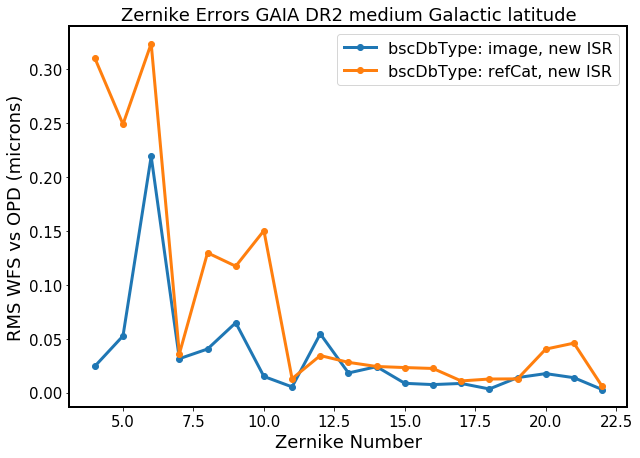

In [235]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

zernikeErrors0 = np.sqrt((wfsData0 - opdData)**2.)
zernikeErrors1 = np.sqrt((wfsData1 - opdData)**2.)
zernikeErrors2 = np.sqrt((wfsData2 - opdData)**2.)

zernikeErrors0 = np.transpose(zernikeErrors0, axes=(1,0))
zernikeErrors1 = np.transpose(zernikeErrors1, axes=(1,0))
zernikeErrors2 = np.transpose(zernikeErrors2, axes=(1,0))

zernikeRms0 = np.sqrt(np.mean(np.square(zernikeErrors0), axis=1))
zernikeRms1 = np.sqrt(np.mean(np.square(zernikeErrors1), axis=1))
zernikeRms2 = np.sqrt(np.mean(np.square(zernikeErrors2), axis=1))


fig,ax = plt.subplots(1,1,figsize=(10,7))
# ax.plot(np.arange(19)+4, zernikeRms0, 
#              '-o', lw=3, label='bscDbType: refCat, old ISR')
ax.plot(np.arange(19)+4, zernikeRms1, 
             '-o', lw=3, label='bscDbType: image, new ISR')
ax.plot(np.arange(19)+4, zernikeRms2, 
             '-o', lw=3, label='bscDbType: refCat, new ISR')
ax.set_xlabel('Zernike Number', size=18)
ax.set_ylabel('RMS WFS vs OPD (microns)', size=18)

ax.legend(fontsize=16)
ax.set_title('Zernike Errors GAIA DR2 medium Galactic latitude', size=18)


Show the postage stamp images...

In [222]:
print(data_dir)
image = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22', detector = 'S00',
                           rerun='run2')



/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/
data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/rerun/run2
Done



## bscDbType : image 

In [223]:
import imp
imp.reload(at)
postage, postFlag =  at.readPostageStars(closed_loop_input_dir,
                                         fname ='postagedonutStarsExtraIntra1.txt' )


Reading info about postage-stamp images from postagedonutStarsExtraIntra1.txt


In [219]:
#postage

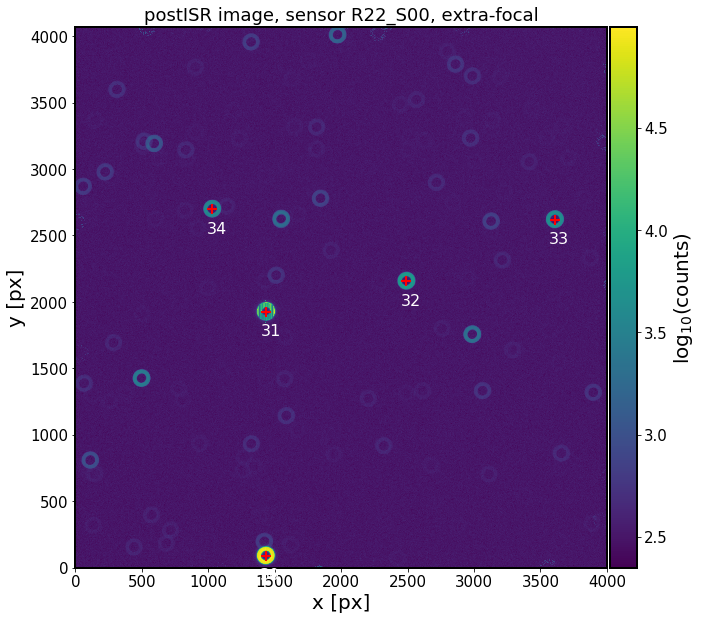

In [224]:
at.plotImage(image,ax=None, log=True, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=True, centroid=False, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/postage
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/postage directory

Available postage stamp images for sensor R22_S00: 

Looking for files that start with "extra_singleSciImg" and contain "R22_S00"...

Found 5 singleSciImg postage stamp images 
['extra_singleSciImg_sensor-R22_S00_star-0_id-30_posX-1305_posY-0.txt', 'extra_singleSciImg_sensor-R22_S00_star-1_id-31_posX-1307_posY-1799.txt', 'extra_singleSciImg_sensor-R22_S00_star-2_id-32_posX-2363_posY-2029.txt', 'extra_singleSciImg_sensor-R22_S00_star-3_id-33_posX-3480_posY-2491.txt', 'extra_singleSciImg_sensor-R22_S00_star-4_id-34_posX-902_posY-2570.txt']

Looking for files that start with "extra_imgDeblend_full" and contain "R22_S00"...

Found 5 imgDeblend_full postage stamp images 
['extra_imgDeblen

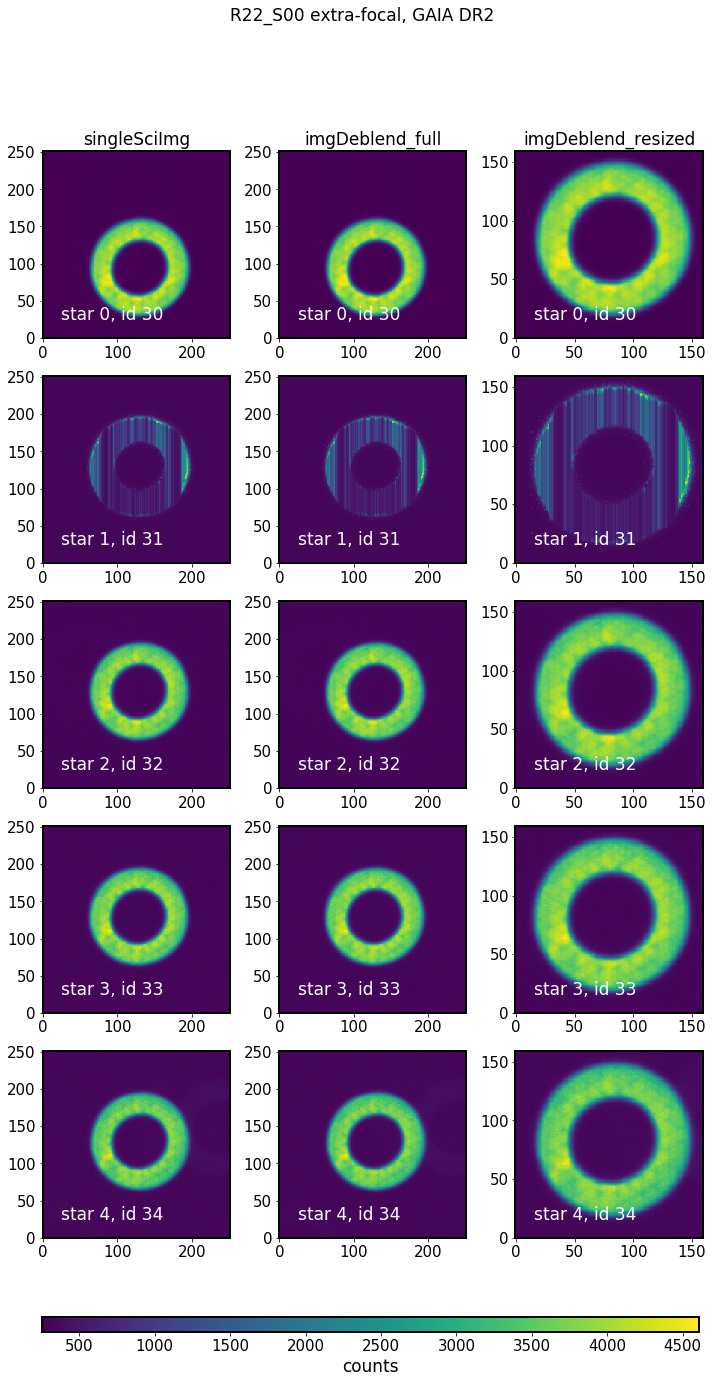

In [233]:
import imp
imp.reload(at)
postage_dir= os.path.join(closed_loop_input_dir, 'postage')
at.plotPostageStamps(postage_dir, sensor='R22_S00', focalType='extra', Nstars=None,
                     testLabel='gaia')

So the actual image with donut positions overlaid make sense ? Why are there so few  donuts per sensor selected? Why is the donut basically on the lower edge of teh sensor selected ?  

## bscDbType : refCat 

Reading info about postage-stamp images from postage2donutStarsExtraIntra.txt


../analysis_tools/analysisTools.py:223: RuntimeWarning: invalid value encountered in log10
  plottable = np.log10(image.T)


Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/postage2
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/postage2 directory

Available postage stamp images for sensor R22_S00: 

Looking for files that start with "extra_singleSciImg" and contain "R22_S00"...

Found 4 singleSciImg postage stamp images 
['extra_singleSciImg_sensor-R22_S00_star-0_id-30_posX-3480_posY-2491.txt', 'extra_singleSciImg_sensor-R22_S00_star-1_id-31_posX-2936_posY-1202.txt', 'extra_singleSciImg_sensor-R22_S00_star-2_id-32_posX-2589_posY-2768.txt', 'extra_singleSciImg_sensor-R22_S00_star-3_id-33_posX-1687_posY-3184.txt']

Looking for files that start with "extra_imgDeblend_full" and contain "R22_S00"...

Found 4 imgDeblend_full postage stamp images 
['extra_imgDeblend_full_sensor-R22_S00_star-0_id-30_posX-3480_posY-2491.txt', 'extra_

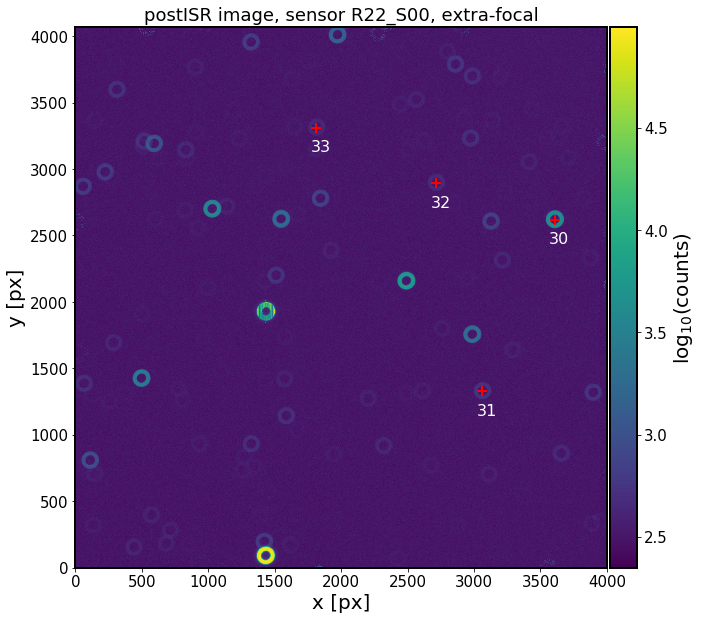

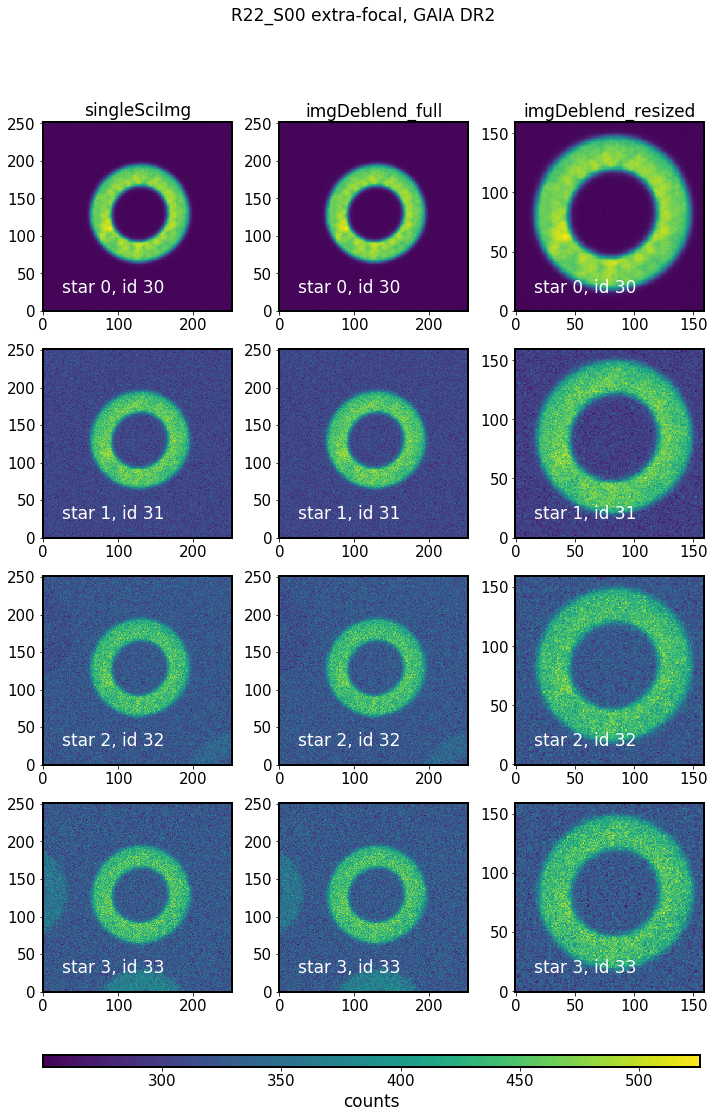

In [234]:
import imp
imp.reload(at)
postage, postFlag =  at.readPostageStars(closed_loop_input_dir,
                                         fname ='postage2donutStarsExtraIntra.txt' )


# use same postISR image as above, but plotting locations of 
# stars chosen by a differetnt method 
at.plotImage(image,ax=None, log=True, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=True, centroid=False, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

import imp
imp.reload(at)
postage_dir= os.path.join(closed_loop_input_dir, 'postage2')
at.plotPostageStamps(postage_dir, sensor='R22_S00', focalType='extra', Nstars=None,
                     testLabel='gaia')



Why is the analysis based on the refCat choosing fainter stars? Why are several bright and isolated stars completely missed ? 